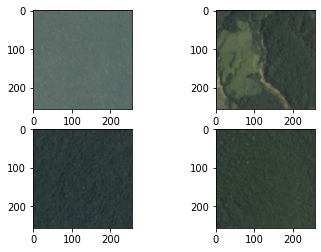

In [1]:
from matplotlib import pyplot
from matplotlib.image import imread
import pandas as pd
# define location of dataset
folder = '../input/planets-dataset/planet/planet/train-jpg/'
# plot first few images
for i in range(4):
  # define subplot
  pyplot.subplot(220 + 1 + i)
  # define filename
  filename = folder + 'train_' + str(i) + '.jpg'
  # load image pixels
  image = imread(filename)
  # plot raw pixel data
  pyplot.imshow(image)
# show the figure
pyplot.show()

In [2]:
train = pd.read_csv('../input/planets-dataset/planet/planet/train_classes.csv')
train

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


In [3]:
list1 = set()
def splitting_tags(tags):
    [list1.add(tag) for tag in tags.split()]
    
# Create a copy of train_classes
train1 = train.copy()
train1['tags'].apply(splitting_tags)
list1 = list(list1)
print(list1)

['partly_cloudy', 'slash_burn', 'primary', 'conventional_mine', 'cultivation', 'haze', 'blooming', 'cloudy', 'artisinal_mine', 'clear', 'water', 'road', 'blow_down', 'bare_ground', 'selective_logging', 'agriculture', 'habitation']


In [4]:
for tag in list1:
    train1[tag] = train1['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
train1['image_name'] = train1['image_name'].apply(lambda x: '{}.jpg'.format(x))
train1

,image_name,tags,partly_cloudy,slash_burn,primary,conventional_mine,cultivation,haze,blooming,cloudy,artisinal_mine,clear,water,road,blow_down,bare_ground,selective_logging,agriculture,habitation
0,train_0.jpg,haze primary,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,train_1.jpg,agriculture clear primary water,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0
2,train_2.jpg,clear primary,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,train_3.jpg,clear primary,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40474,train_40474.jpg,clear primary,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
40475,train_40475.jpg,cloudy,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
40476,train_40476.jpg,agriculture clear primary,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
40477,train_40477.jpg,agriculture clear primary road,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0


In [5]:
columns = list(train1.columns[2:])

In [6]:
def label(y_true, y_pred, epsilon = 1e-4):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(y_true * y_pred, axis = 1)
    fp = tf.reduce_sum(y_pred, axis = 1) - tp
    fn = tf.reduce_sum(y_true, axis = 1) - tp
    
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)
        
    tn = tf.reduce_sum(tf.cast(tf.logical_not(y_true), tf.float32)
                       * tf.cast(tf.logical_not(y_pred), tf.float32), axis = 1)
    
    return (tp+tn)/(tp+tn+fp+fn+epsilon)

In [7]:
def fbeta(y_true, y_pred, beta = 2, epsilon = 1e-4):
    
    beta_squared = beta**2
    
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(y_true * y_pred, axis = 1)
    fp = tf.reduce_sum(y_pred, axis = 1) - tp
    fn = tf.reduce_sum(y_true, axis = 1) - tp
    
    precision = tp/(tp+fp+epsilon)
    recall = tp/(tp+fn+epsilon)
    
    fb = (1+beta_squared)*precision*recall / (beta_squared*precision+recall+epsilon)
    return fb

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, MaxPooling2D,Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam, SGD

save_best_check_point = ModelCheckpoint(filepath = 'model.hdf5', 
                                        monitor = 'val_fbeta',
                                        mode = 'max',
                                        save_best_only = True,
                                        save_weights_only = True)

In [9]:
#cnn model
def build_model():
    model = Sequential()
    model.add(BatchNormalization(input_shape=(128, 128, 3)))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(17, activation='sigmoid'))

    opt = Adam(lr=1e-4)

    model.compile(loss='binary_crossentropy',
              # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
              optimizer=opt,
              metrics=[label, fbeta])

    return model



In [10]:

trainim = ImageDataGenerator(rescale = 1/255, validation_split = 0.2)
traingen = trainim.flow_from_dataframe(dataframe=train1,
                                                directory ="../input/planets-dataset/planet/planet/train-jpg",  
                                                x_col="image_name", y_col=columns, subset="training", 
                                                batch_size=16,seed=2021, shuffle=True, 
                                                class_mode="raw", target_size=(128,128))

valgen = trainim.flow_from_dataframe(dataframe=train1,
                                                directory ="../input/planets-dataset/planet/planet/train-jpg",  
                                                x_col="image_name", y_col=columns, subset="validation", 
                                                batch_size=16,seed=2021, shuffle=True, 
                                                class_mode="raw", target_size=(128,128))

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [11]:
import numpy as np
steptrain = int(np.ceil(traingen.samples / traingen.batch_size))
stepval = int(np.ceil(valgen.samples / valgen.batch_size))


In [12]:
model1 = build_model()

2022-03-21 14:15:53.531294: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 14:15:53.620789: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 14:15:53.621504: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 14:15:53.623116: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [13]:
model1.fit(x = traingen, steps_per_epoch = steptrain, validation_data = valgen, 
           validation_steps = stepval,epochs = 30, 
           callbacks = [save_best_check_point])

2022-03-21 14:15:56.199311: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-03-21 14:15:58.202301: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2024/2024 [==============================] - 315s 152ms/step - loss: 0.2187 - label: 0.9166 - fbeta: 0.6986 - val_loss: 0.1666 - val_label: 0.9334 - val_fbeta: 0.7607
Epoch 2/30
2024/2024 [==============================] - 115s 57ms/step - loss: 0.1638 - label: 0.9354 - fbeta: 0.7856 - val_loss: 0.1482 - val_label: 0.9421 - val_fbeta: 0.7960
Epoch 3/30
2024/2024 [==============================] - 114s 56ms/step - loss: 0.1478 - label: 0.9415 - fbeta: 0.8079 - val_loss: 0.1279 - val_label: 0.9498 - val_fbeta: 0.8355
Epoch 4/30
2024/2024 [==============================] - 115s 57ms/step - loss: 0.1375 - label: 0.9455 - fbeta: 0.8239 - val_loss: 0.1239 - val_label: 0.9516 - val_fbeta: 0.8476
Epoch 5/30
2024/2024 [==============================] - 116s 57ms/step - loss: 0.1310 - label: 0.9482 - fbeta: 0.8356 - val_loss: 0.1223 - val_label: 0.9530 - val_fbeta: 0.8511
Epoch 6/30
2024/2024 [==============================] - 117s 58ms/step - loss: 0.1255 - label: 0.9506 - fbeta: 0.8450 - val_l

In [14]:
model2 = build_model()

In [15]:
##adding .jpg extension to image name in the sample submission file
sample = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
sample1 = sample.copy()
sample1['image_name'] = sample1['image_name'].apply(lambda x: '{}.jpg'.format(x))
sample1.head()

,image_name,tags
0,test_0.jpg,primary clear agriculture road water
1,test_1.jpg,primary clear agriculture road water
2,test_2.jpg,primary clear agriculture road water
3,test_3.jpg,primary clear agriculture road water
4,test_4.jpg,primary clear agriculture road water


In [16]:
#loading in the weights of the trained model so we can make predictions with it
model2.load_weights('model.hdf5')

In [17]:
#we divide the sample submission file into two splits, first test1_df which contains the first 40669 images 
test1 = sample1.iloc[:40669]['image_name'].reset_index().drop('index', axis =1)
test1.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [18]:
testim = ImageDataGenerator(rescale = 1/255)


testgen1 = testim.flow_from_dataframe(dataframe=test1, 
                                                directory="../input/planets-dataset/planet/planet/test-jpg", 
                                                x_col="image_name", y_col=None, batch_size=16, 
                                                shuffle=False, class_mode=None, target_size=(128,128))

steptest1 = int(np.ceil(testgen1.samples/testgen1.batch_size))

Found 40669 validated image filenames.


In [19]:
testgen1.reset()
pred1 = model2.predict(testgen1, steps = steptest1, verbose = 1)

2542/2542 [==============================] - 257s 101ms/step


In [20]:
filename1 = testgen1.filenames

predtag1 = pd.DataFrame(pred1)
predtag1 = predtag1.apply(lambda x: ' '.join(np.array(list1)[x>0.5]), axis = 1)

result1 = pd.DataFrame({'image_name': filename1, 'tags': predtag1})
result1.head()

,image_name,tags
0,test_0.jpg,primary clear
1,test_1.jpg,primary clear
2,test_2.jpg,partly_cloudy primary
3,test_3.jpg,primary clear agriculture
4,test_4.jpg,cloudy


In [21]:
test2 = sample1.iloc[40669:]['image_name'].reset_index().drop('index', axis =1)
test2.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [22]:
testgen2 = testim.flow_from_dataframe(dataframe=test2, 
                                                directory="../input/planets-dataset/test-jpg-additional/test-jpg-additional", 
                                                x_col="image_name", y_col=None, batch_size=16, 
                                                shuffle=False, class_mode=None, target_size=(128,128))

steptest2 = int(np.ceil(testgen2.samples/testgen2.batch_size))

Found 20522 validated image filenames.


In [23]:
testgen2.reset()
pred2 = model2.predict(testgen2, steps = steptest2, verbose = 1)

1283/1283 [==============================] - 166s 129ms/step


In [24]:
filenames2 = testgen2.filenames

predtags2 = pd.DataFrame(pred2)
predtags2 = predtags2.apply(lambda x: ''.join(np.array(list1)[x>0.5]), axis = 1)

result2 = pd.DataFrame({'image_name': filenames2, 'tags': predtags2})
result2.head()

,image_name,tags
0,file_0.jpg,primaryclear
1,file_1.jpg,partly_cloudyprimarybare_groundagriculture
2,file_10.jpg,primarywaterroadagriculture
3,file_100.jpg,primaryclearwater
4,file_1000.jpg,primaryclear


In [25]:

result3 = pd.concat([result1, result2])

result3 = result3.reset_index().drop('index', axis =1)

print(result3.shape)
result3.head()

(61191, 2)


,image_name,tags
0,test_0.jpg,primary clear
1,test_1.jpg,primary clear
2,test_2.jpg,partly_cloudy primary
3,test_3.jpg,primary clear agriculture
4,test_4.jpg,cloudy


In [26]:
result3['image_name'] = result3['image_name'].apply(lambda x: x[:-4])
result3.head()

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,partly_cloudy primary
3,test_3,primary clear agriculture
4,test_4,cloudy


In [27]:
result3.to_csv('tobykaggle.csv', index = False)